In [36]:
import time
from style import *
from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate, displace
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt
from qutip import sprepost, spre, spost

import UD_liouv as RC
import driving_liouv as EM
import scipy as sp

#import phonon_weak_coupling as WC
from utils import beta_f, J_underdamped, J_minimal_hard, J_multipolar, J_poly
from utils import ground_and_excited_states, initialise_TLS, Occupation
import pickle
from sympy import coth

In [37]:
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rc('grid', linestyle="--", color='grey')
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.3
plt.rcParams['lines.linewidth'] = 2.3
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 21
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']


colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
colors+=colours
colors+=['#8279b8'] 

In [38]:
def load_obj(name ):
    with open(name + '.pickle', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name ):
    with open(name + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [39]:
ev_to_inv_cm = 8065.5
#inv_ps_to_inv_cm = 33.356227807
inv_ps_to_inv_cm = 5.309

G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.

epsilon = 1. * ev_to_inv_cm
w0= 400. #50e-3 * ev_to_inv_cm
Gamma = 80. #10e-3 * ev_to_inv_cm
lifetime = 100. #ps
Gamma_EM = (1/lifetime)*inv_ps_to_inv_cm

timelist = np.linspace(0, 1*1e3, 3000)/inv_ps_to_inv_cm

In [6]:

def displacement(alpha_ph):
    return np.sqrt(np.pi * alpha_ph * w0 / 2.)/w0

def L_residual(alpha_ph, T_ph, N):
    gamma = Gamma / (2. * np.pi * w0)  # coupling between RC and residual bath
    
    Lambda = np.sqrt(np.pi * alpha_ph * w0 / 2.)  # coupling strength between the TLS and RC
    Omega = w0
    a = destroy(N)
    shift = pi*alpha_ph/2
    I_sys = qeye(2)
    I_N = qeye(N)
    H_S = (epsilon+shift)*tensor(sigma.dag()*sigma, I_N) + Lambda*tensor(sigma.dag()*sigma, (a + a.dag())) 
    H_S +=  Omega*tensor(I_sys, a.dag()*a)
    
    S = tensor(I_sys, (a + a.dag()))
    zeta  = 0
    energies, states = H_S.eigenstates()
    dim = len(energies)
    for j in range(dim):
        for k in range(dim):
            state_k, state_j = states[k], states[j]
            pos_jk = S.matrix_element(state_j.dag(), state_k)
            if np.abs(pos_jk)> 0:
                energy_jk = energies[j]-energies[k]
                dyad_jk = state_j*state_k.dag()
                if np.abs(energy_jk)<1e-12:
                    zeta+= pi*0.695*T_ph*gamma*pos_jk*dyad_jk
                else:
                    zeta+= (pi/2)*gamma*energy_jk*(float(coth(energy_jk/(2*0.695*T_ph)))+1)*pos_jk*dyad_jk
    L_ = sprepost(S, zeta) - spost(zeta*S) + sprepost(zeta.dag(), S) - spre(S*zeta.dag())
    return H_S, L_, tensor(sigma, I_N)

In [8]:
# This shows that old and new codes are the same
def test_coherences(alpha, T_ph, N, tf=0.015):
    # tf in picoseconds
    print(epsilon, alpha, Gamma, w0, T_ph, N)
    
    H_model, L_model, A_EM = L_residual(alpha, T_ph, N)
    rho_0 = tensor(0.5*(E+G)*(E+G).dag(), thermal_dm(N, Occupation(w0, T_ph)))
    rho_0/=rho_0.tr()
    a = destroy(N)
    e_ops=[tensor(E*G.dag(), qeye(N)), tensor(qeye(2), a+a.dag()), A_EM.dag()*A_EM]
    
    timelist_coh = np.linspace(0, tf, 10000)/inv_ps_to_inv_cm
    dynamics_ = mesolve(H_model, rho_0, timelist_coh, c_ops=[L_model], 
                        e_ops=e_ops, progress_bar=True, 
                        options=qt.Options(nsteps=6000))
    return timelist_coh*inv_ps_to_inv_cm, dynamics_

def test_coherences_old(alpha, T_ph, N, tf=0.015):
    # tf in picoseconds
    print(epsilon, alpha, Gamma, w0, T_ph, N)
    
    L_model, H_model, A_EM, A_nrwa, Z, wRC, kappa, _= RC.RC_function_UD(sigma, epsilon, 
                                                                    T_ph, Gamma, 
                                                                    w0, alpha, N)
    rho_0 = tensor(0.5*(E+G)*(E+G).dag(), thermal_dm(N, Occupation(w0, T_ph)))
    rho_0/=rho_0.tr()
    a = destroy(N)
    e_ops=[tensor(E*G.dag(), qeye(N)), tensor(qeye(2), a+a.dag()), A_EM.dag()*A_EM]
    
    timelist_coh = np.linspace(0, tf, 9000)/inv_ps_to_inv_cm
    dynamics_ = mesolve(H_model, rho_0, timelist_coh, c_ops=[L_model], 
                        e_ops=e_ops, progress_bar=True, 
                        options=qt.Options(nsteps=6000))
    return timelist_coh*inv_ps_to_inv_cm, dynamics_


H_model, L_model, A_EM = L_residual(0.5*epsilon, 300., 15)
L_old, H_old, A_EM, A_nrwa, Z, wRC, kappa, _= RC.RC_function_UD(sigma, epsilon, 
                                                                    300., Gamma, 
                                                                    w0, 0.5*epsilon, 15)
assert(np.max((L_model-L_old).full())<1e-10)

w_RC=403.27500000000003 | TLS splitting = 8065.5 | RC-res. coupling=0.03 | TLS-RC coupling=1598.31 | Gamma_RC=80.66 | alpha_ph=4032.75 | N=15 |


In [9]:
# This shows that coherences from CC dissipator agrees with exact solution
# & that this converges in around 15 states
# & that the old and new version of the CC code agree
# & that the CC displacement agrees with the analytic value 
# & it converges in around 50 states for alpha=0.5*epsilon

alpha_prop = 0.5
ti = time.time()
# only needs roughly 15 states to converge the electonic coherences, CC displacement needs far more
timelist_coh, dyn_coh = test_coherences(epsilon*alpha_prop, 300., 49, tf=0.55)
print(time.time()- ti)

timelist_coh, dyn_coh_old = test_coherences(epsilon*alpha_prop, 300., 15, tf=0.55)
print(time.time()- ti)

import exact_IB as exact
timelist_exact = np.linspace(0, 0.015, 130)/inv_ps_to_inv_cm
rho_01 = np.array(exact.exact_dynamics(epsilon, epsilon*alpha_prop, 0., 
                                           w0, Gamma, 1/(0.695*300), 0.5*(E+G)*(E+G).dag(), 
                                           timelist_exact, overdamped=False))*0.5


8065.5 4032.75 80.655 403.27500000000003 300.0 49


KeyboardInterrupt: 

(0, 0.55)

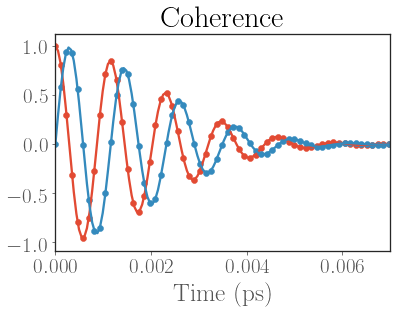

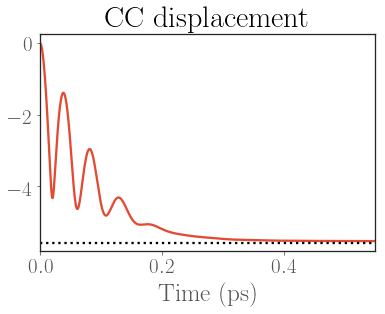

In [214]:
plt.title("Coherence")
plt.plot(timelist_coh, 2*dyn_coh.expect[0].real)
#plt.plot(timelist_coh, 2*dyn_coh_old.expect[0])
plt.plot(timelist_coh, 2*dyn_coh.expect[0].imag)
plt.scatter(timelist_exact*inv_ps_to_inv_cm, 2*rho_01.real)
plt.scatter(timelist_exact*inv_ps_to_inv_cm, -2*rho_01.imag)
plt.xlabel("Time (ps)")
plt.xlim(0,0.007)

plt.figure()
plt.title("CC displacement")
plt.plot(timelist_coh, dyn_coh.expect[1])
plt.xlabel("Time (ps)")
plt.axhline(-displacement(epsilon*alpha_prop), ls='dotted', color='k')
plt.xlim(0, timelist_coh[-1])

In [28]:
# Additive model

def lindblad(op):
    opdop = op.dag()*op
    return 2*sprepost(op, op.dag()) - (spre(opdop) + spost(opdop))
    
def L_additive(A, T_EM):
    n = Occupation(epsilon, T_EM)
    return (Gamma_EM/2.)*((n+1)*lindblad(A) + n*lindblad(A.dag()))

def thermal_state(T_):
    th_un = ((-epsilon*E*E.dag()/(0.695*T_)).expm())
    return ((th_un/th_un.norm())*E*E.dag()).tr()

# The non-secular non-additive model
def J_EM(w):
    return ((w/epsilon)**3)*(Gamma_EM/(2*pi))

def rate_up(w, T):
    n = Occupation(w, T)
    rate = pi * n * J_EM(w)
    return rate

def rate_down(w, T):
    n = Occupation(w, T)
    rate = pi * (n + 1. ) * J_EM(w)
    return rate

def commutators(A, B):
    return spre(A*B) - sprepost(B, A) + spost(B.dag()*A.dag()) - sprepost(A.dag(), B.dag())

def L_optical(H, sigma_CC, T_EM):
    Xi_1 = 0
    Xi_2 = 0
    energies, states = H.eigenstates()
    dim = len(energies)
    sigma_test = 0
    for j in range(dim):
        for k in range(dim):
            state_k, state_j = states[k], states[j]
            sigma_jk = sigma_CC.matrix_element(state_j.dag(), state_k)
            sigma_dag_kj = (sigma_CC.dag()).matrix_element(state_k.dag(), state_j)
            
            energy_jk = energies[j]-energies[k]
            dyad_jk = state_j*state_k.dag()
            Xi_1 += sigma_jk*rate_up(energy_jk, T_EM)*dyad_jk
            Xi_2 += sigma_dag_kj*rate_down(energy_jk, T_EM)*dyad_jk.dag()
    L = -commutators(sigma_CC.dag(), Xi_1) - commutators(sigma_CC, Xi_2)
    return L
    


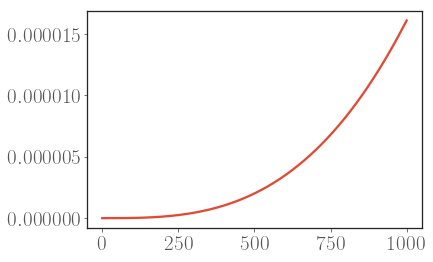

In [11]:
w = np.linspace(0,1000, 10000)
plt.plot(w, J_EM(w))

In [12]:
def build_model(alpha, T_ph, T_EM, N, silent=True):
    H_model, L_model, A_EM = L_residual(alpha, T_ph, N)
    L_model += L_optical(H_model, A_EM, T_EM)
    #L_model += EM.L_non_rwa(H_model, A_EM+A_EM.dag(), epsilon, Gamma_EM, T_EM, J_multipolar, principal=False, 
    #                            silent=True, alpha=0., tol=1e-5)
    return H_model, L_model, A_EM


def build_additive_model(alpha, T_ph, T_EM, N, silent=True):
    H_model, L_model, A_EM = L_residual(alpha, T_ph, N)
    A_EM = tensor(sigma, qeye(N))
    L_model += L_additive(A_EM, T_EM)
    return H_model, L_model, A_EM


# Population dynamics

# Figure 3.2 (a)
Emitter population dynamics from additive and non-additive theories for increasing vibrational coupling.


In [13]:
def compare_phonon_free_dynamics(T):
    dynamics = []
    L_na = L_optical(epsilon*E*E.dag(), sigma, T)
    #L_na = EM.L_non_rwa(epsilon*E*E.dag(), sigma+sigma.dag(), epsilon, Gamma_EM, T, J_multipolar, principal=False, 
    #                            silent=False, alpha=0., tol=1e-5)
    liouvs = [L_na, L_additive(sigma, T)]
    for L_test in liouvs:
        dynamics.append(mesolve(epsilon*E*E.dag(), E*E.dag(), timelist, c_ops=[L_test], 
                        e_ops=[E*E.dag()], progress_bar=None, 
                        options=qt.Options(nsteps=8000)).expect[0])
    return dynamics[0], dynamics[1]

Text(0,0.5,'$\\rho_{e}$')

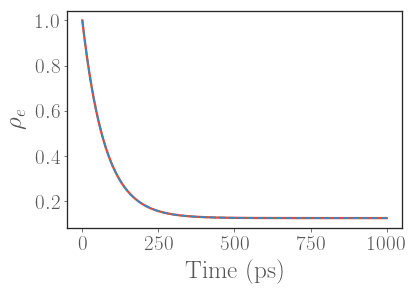

In [14]:
P_nonsec, P_add = compare_phonon_free_dynamics(6000.)
plt.plot(timelist*inv_ps_to_inv_cm, P_nonsec)
plt.plot(timelist*inv_ps_to_inv_cm, P_add, ls='dashed', linewidth=1.8)
plt.xlabel("Time (ps)")
plt.ylabel(r"$\rho_{e}$")

In [15]:
# Non-additive model

def calculate_dynamics(alpha, T_EM, N, model):
    T_ph = 300.
    H_test, L_test, A_EM = model(alpha, T_ph, T_EM, N)
    rho_0 = tensor(E*E.dag(), thermal_dm(N, Occupation(w0, T_ph)))
    e_ops=[A_EM.dag()*A_EM]
    
    dynamics_ = mesolve(H_test, rho_0, timelist, c_ops=[L_test], 
                        e_ops=e_ops, progress_bar=True, 
                        options=qt.Options(nsteps=8000))
    return dynamics_.expect[0]

def plot_dynamics(timelist_cm, dynamics_, linestyle='solid'):
    plt.plot(timelist_cm*inv_ps_to_inv_cm/1000, dynamics_.expect[0], linestyle=linestyle)
    
def plot_population(timelist_cm, pop, alpha_over_ep, linestyle='solid'):
    if linestyle=='dashed':
        label=None
    else:
        label=r'$\alpha\epsilon^{-1}$'+'={}'.format(alpha_over_ep)
    plt.plot(timelist_cm*inv_ps_to_inv_cm/1000, pop, linestyle=linestyle, 
             label=label)

10.0%. Run time:   0.36s. Est. time left: 00:00:00:03
20.0%. Run time:   0.77s. Est. time left: 00:00:00:03
30.0%. Run time:   1.23s. Est. time left: 00:00:00:02
40.0%. Run time:   1.68s. Est. time left: 00:00:00:02
50.0%. Run time:   2.15s. Est. time left: 00:00:00:02
60.0%. Run time:   2.65s. Est. time left: 00:00:00:01
70.0%. Run time:   3.16s. Est. time left: 00:00:00:01
80.0%. Run time:   3.60s. Est. time left: 00:00:00:00
90.0%. Run time:   4.00s. Est. time left: 00:00:00:00
Total run time:   4.44s
10.0%. Run time: 123.39s. Est. time left: 00:00:18:30
20.0%. Run time: 248.83s. Est. time left: 00:00:16:35
30.0%. Run time: 375.35s. Est. time left: 00:00:14:35
40.0%. Run time: 500.47s. Est. time left: 00:00:12:30
50.0%. Run time: 625.66s. Est. time left: 00:00:10:25
60.0%. Run time: 748.04s. Est. time left: 00:00:08:18
70.0%. Run time: 871.57s. Est. time left: 00:00:06:13
80.0%. Run time: 994.99s. Est. time left: 00:00:04:08
90.0%. Run time: 1118.03s. Est. time left: 00:00:02:04
Tot

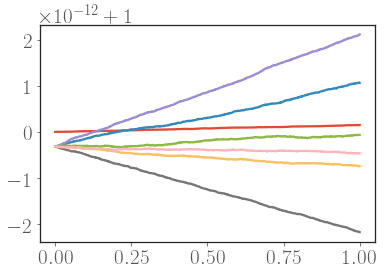

In [43]:
alpha_over_epsilon = [0, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25]


#H_test, L_test, A_EM = build_model(alpha, T_ph, Gamma_EM, T_EM, N)

data_fig2a = []
N_vals_f2a = np.array([3, 17, 18, 19, 22, 25, 30])
#N_vals_f2a = np.array([5, 5, 5, 5, 5, 5, 5]) # test

#alpha_t = 0.25*epsilon
#T_t = 300.
"""
dyn_a = calculate_dynamics(alpha_t, T_t, 3, build_additive_model)
plot_population(timelist, dyn_a, 0., linestyle='dashed')
dyn = calculate_dynamics(alpha_t, T_t,  24, build_model)
plot_population(timelist, dyn, 0.)
#plt.legend()
"""

for alpha_over_ep, N in zip(alpha_over_epsilon, N_vals_f2a):
    dyn = calculate_dynamics(alpha_over_ep*epsilon, 0., N+1, build_model)
    data_fig2a.append(dyn)
    plot_population(timelist, dyn, alpha_over_ep)


In [ ]:
plot_population(timelist, dyn_a, 0, linestyle='dashed')
plot_population(timelist, dyn, 0.25)
plt.legend()
plt.xlabel("Time (ps)")
plt.ylabel(r"$\rho_e$")
#plt.savefig('thesis-figures/dynamics.pdf')

Additive and non-additive agree at zero phonon-coupling. Whatever the issue is must be to do with the inclusion of phonons, but not the phonons themselves as these agree with the exact solution. It could be to do with my implementation of the non-secular code. When N gets high enough that the highest energy states are larger than the exciton splitting, the value of the excited state population starts to decrease. ~~Perhaps I should try the Non-RWA code to see if that is better?~~

In [14]:
save_obj([alpha_over_epsilon, data_fig2a], "thesis-data/dynamics_fig_2a")

# Decay rates

# Figure 3.3 (b)

Total decay rate $\Gamma_{e\to g} = \sum_n \langle g, n | \mathcal{L} [\rho_X(0)] |g, n\rangle $ from a non-displaced electronically excited vibrational thermal state.

In [17]:
def rate_from_thermal_to_ground(alpha_ph, N, model):
    H_test, L_test, A_EM = model(alpha_ph, 300., 300., N)
    
    decay_rate = 0
    therm = thermal_dm(N, Occupation(w0, 300.))
    b = destroy(N)
    
    disp = np.sqrt(np.pi * alpha_ph * w0 / 2.) / w0
    D = (disp*(b.dag() - b)).expm()
    init_rho = tensor(E*E.dag(), D.dag()*therm*D)
    for j in range(N):
        final_ket = tensor(G, qt.basis(N,j))
        L_rho0_prod = qt.vector_to_operator(L_test*qt.operator_to_vector(init_rho))
        decay_rate += L_rho0_prod.matrix_element(final_ket.dag(), final_ket)
        
    return decay_rate

def rate_vs_alpha(alpha_ratios, nmin=10, nmax=60):
    rates_nadd = []
    rates_add = []
    N_vals = [int(n) for n in np.linspace(nmin, nmax, len(alpha_ratios))]
    for alpha_r, N in zip(alpha_ratios, N_vals):
        rates_nadd.append(rate_from_thermal_to_ground(alpha_r*epsilon, N, build_model))
        rates_add.append(rate_from_thermal_to_ground(alpha_r*epsilon, N, build_additive_model))
    return np.array(rates_nadd), np.array(rates_add)


In [18]:
# This shows that you need roughly the same number of states as for CC dynamics
# because you need to build displacement operators

alpha_ratios = np.linspace(0,0.6, 5)
rates_nadd, rates_add = rate_vs_alpha(alpha_ratios, nmin=10, nmax=60)


/Users/henrymaguire/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 1.05)

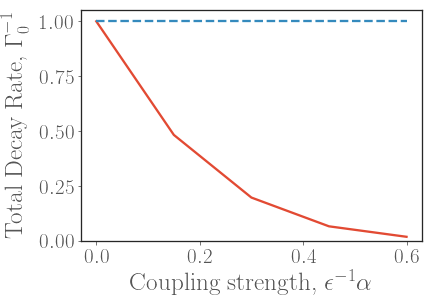

In [19]:
plt.plot(alpha_ratios, rates_nadd/Gamma_EM, ls='solid')
plt.plot(alpha_ratios, rates_add/Gamma_EM, ls='dashed')
plt.xlabel(r"Coupling strength, $\epsilon^{-1} \alpha$")
plt.ylabel(r"Total Decay Rate, $\Gamma_0^{-1}$")
plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.98, wspace=0.24, hspace=0.015)
plt.ylim(0, 1.05)
#plt.savefig("thesis-figures/fig2a.pdf")


# Phonon-coupling dependence

# Figure 3.3 (a)

Steady-state emitter population as afunction of the electron-phonon coupling. $T_EM = 6000K$, $12000$ and $60000$.

In [21]:
def get_steadystate_population(alpha, T_ph, T_EM, N):
    H_test, L_test, A_EM = build_model(alpha, T_ph, T_EM, N)
    return (steadystate(H_test, [L_test])*A_EM.dag()*A_EM).tr()

def plot_convergence(N_conv, conv_data, alpha_ratio):
    plt.plot(N_conv, conv_data, label=r'$\alpha\epsilon^{-1} = $'+'{}'.format(alpha_ratio))
    plt.xlabel('N')
    plt.ylabel(r'$\rho_e$')
    plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.98, wspace=0.24, hspace=0.015)
    plt.legend()
# test

assert((get_steadystate_population(0., 300., 6000., 6) - thermal_state(6000.))<1e-12)

## Steady-state convergence test

In [40]:
conv_dat_1 = []
N_vals_conv_1 = range(5, 43)
for N_ in N_vals_conv_1:
    pop = get_steadystate_population(0.5*epsilon, 300., 6000., N_)
    conv_dat_1.append(pop)

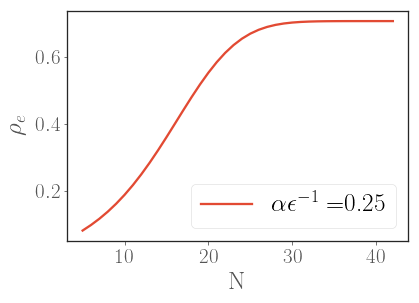

In [41]:
plot_convergence(N_vals_conv_1, conv_dat_1, 0.25)
#plt.savefig('thesis-figures/convergence_1.pdf')


In [ ]:
conv_dat_2 = []
N_vals_conv_2 = range(5, 51)
for N_ in N_vals_conv_2:
    pop = get_steadystate_population(0.5*epsilon, 300., 6000., N_)
    conv_dat_2.append(pop)
    #print(pop)

In [ ]:
plot_convergence(N_vals_conv_2, conv_dat_2, alpha_ratio)
#plt.savefig('thesis-figures/convergence_1.pdf')

In [ ]:
conv_dat_3 = []
N_vals_conv_3 = range(5, 56)
for N_ in N_vals_conv_3:
    pop = get_steadystate_population(0.5*epsilon, 300., 6000., N_)
    conv_dat_3.append(pop)
    print(pop)

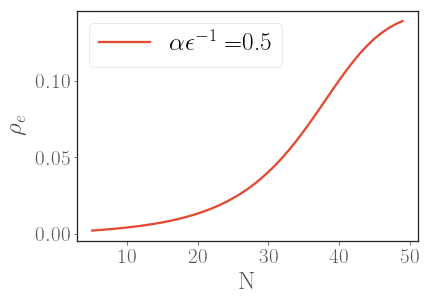

In [262]:
plot_convergence(N_vals_conv_3, conv_dat_3, 0.5)
plt.savefig('thesis-figures/convergence_2.pdf')

In [ ]:
# Trying to get the data to converge. You need many many states.
conv_dat = []
N_vals_conv = range(5, 58)
for N_ in N_vals_conv:
    pop = get_steadystate_population(0.6*epsilon, 300., 6000., N_)
    conv_dat.append(pop)
    print(pop)

16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 5
Calculating non-RWA Liouvilliian took 0.15046977996826172 seconds.
0.00038048441467276254
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 6
Calculating non-RWA Liouvilliian took 0.19282317161560059 seconds.
0.0004391903791655963
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 7
Calculating non-RWA Liouvilliian took 0.27168893814086914 seconds.
0.000503663955134003
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 8
Calculating non-RWA Liouvilliian took 0.35973095893859863 seconds.
0.0005749138813949537
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 9
Calculating non-RWA Liouvilliian took 0.44681286811828613 seconds.
0.0006539913051010536
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 10
Calculating non-RWA 

Calculating non-RWA Liouvilliian took 19.397917985916138 seconds.
0.31038940527435777
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 52
Calculating non-RWA Liouvilliian took 19.938005924224854 seconds.
0.3274973318321556
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 53
Calculating non-RWA Liouvilliian took 19.599107027053833 seconds.
0.335092467006248
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 54
Calculating non-RWA Liouvilliian took 21.37287211418152 seconds.
0.3338281565609667
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 55
Calculating non-RWA Liouvilliian took 21.67601990699768 seconds.
0.32562377382026264
16131.0 12904.800000000001 80.655 403.27500000000003 300.0 0.053090000000000005 6000.0 56
Calculating non-RWA Liouvilliian took 22.34812903404236 seconds.
0.3128539285935327
16131.0 12904.800000000001 80.655 403.2750

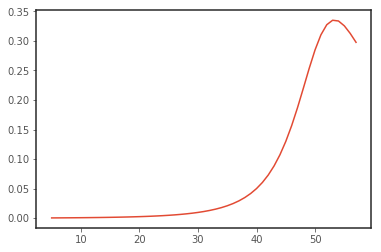

In [143]:
# Trying to get the data to converge. You need many many states.
conv_dat = []
N_vals_conv = range(5, 58)
for N_ in N_vals_conv:
    pop = get_steadystate_population(0.8*epsilon, 300., 6000., N_)
    conv_dat.append(pop)
    print(pop)


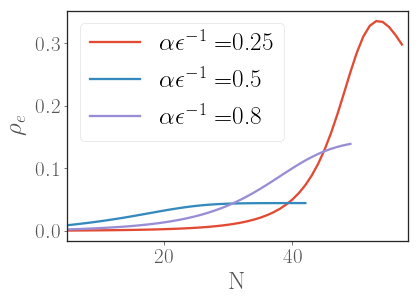

In [269]:
plot_convergence(N_vals_conv, conv_dat, 0.25)
plot_convergence(N_vals_conv_1, conv_dat_1, 0.5)
plot_convergence(N_vals_conv_3, conv_dat_3, 0.8)
plt.xlim(5,58)
plt.savefig('thesis-figures/convergence.pdf')
plt.legend()

In [22]:
alpha_over_epsilon_f3 = np.linspace(0, 0.7,15)
#N_vals_f3 = [int(n)+1 for n in np.linspace(10, 23,len(alpha_over_epsilon_f3))]
N_vals_f3 = [int(n)+1 for n in np.linspace(20, 57,len(alpha_over_epsilon_f3))]
print(N_vals_f3)
data_fig3a = []
temps = [6e3, 12e3, 60e3]
for T_EM_3a in temps:
    row = []
    for N_3a, aoe_3a in zip(N_vals_f3, alpha_over_epsilon_f3):
        alpha_3a = aoe_3a*epsilon
        print(alpha_3a, N_3a, T_EM_3a)
        row.append(get_steadystate_population(alpha_3a, 300., T_EM_3a, N_3a))
    data_fig3a.append(row)

[21, 23, 26, 28, 31, 34, 36, 39, 42, 44, 47, 50, 52, 55, 58]
0.0 21 6000.0
403.275 23 6000.0
806.55 26 6000.0
1209.825 28 6000.0
1613.1 31 6000.0
2016.3749999999998 34 6000.0
2419.65 36 6000.0
2822.9249999999997 39 6000.0
3226.2 42 6000.0
3629.4749999999995 44 6000.0
4032.7499999999995 47 6000.0
4436.025 50 6000.0
4839.3 52 6000.0
5242.574999999999 55 6000.0
5645.849999999999 58 6000.0
0.0 21 12000.0
403.275 23 12000.0
806.55 26 12000.0
1209.825 28 12000.0
1613.1 31 12000.0
2016.3749999999998 34 12000.0
2419.65 36 12000.0
2822.9249999999997 39 12000.0
3226.2 42 12000.0
3629.4749999999995 44 12000.0
4032.7499999999995 47 12000.0
4436.025 50 12000.0
4839.3 52 12000.0
5242.574999999999 55 12000.0
5645.849999999999 58 12000.0
0.0 21 60000.0
403.275 23 60000.0
806.55 26 60000.0
1209.825 28 60000.0
1613.1 31 60000.0
2016.3749999999998 34 60000.0
2419.65 36 60000.0
2822.9249999999997 39 60000.0
3226.2 42 60000.0
3629.4749999999995 44 60000.0
4032.7499999999995 47 60000.0
4436.025 50 60000.0
4

0.1262894484385515
0.2754616390284962
0.45179586718087233


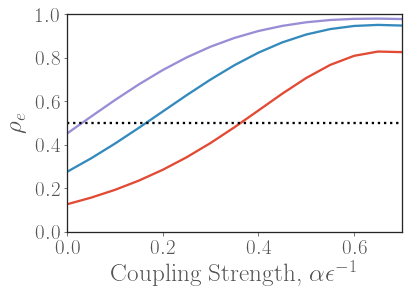

In [33]:
for T, row in zip(temps, data_fig3a):
    plt.plot(alpha_over_epsilon_f3, row)
    print(row[0])
    plt.ylim(0,1)
    plt.xlim(alpha_over_epsilon_f3[0], alpha_over_epsilon_f3[-1])
    plt.subplots_adjust(left=0.14, bottom=0.20, right=0.97, top=0.97, wspace=0.24, hspace=0.015)
plt.xlabel(r'Coupling Strength, $\alpha\epsilon^{-1}$')
plt.ylabel(r'$\rho_e$')
plt.axhline(0.5, ls='dotted', color='k')
#plt.grid()
plt.savefig("thesis-figures/fig_3a_1eV.pdf")

In [29]:
thermal_state(60000)

0.45179586718165815

In [24]:
save_obj(data_fig3a, "thesis-data/dynamics_fig_3a_1eV")

In [303]:
print(get_steadystate_population(epsilon*0.6, 300., 12000., 40))
print(get_steadystate_population(epsilon*0.6, 300., 12000., 45))

0.7452110790300497
0.837301928547984


In [8]:
print(get_steadystate_population(400, 300., 12000., 15))
print(get_steadystate_population(400, 300., 12000., 16))

(16131.0, 300.0, 80.655, 403.27500000000003, 400, 15)
0.141155249205
(16131.0, 300.0, 80.655, 403.27500000000003, 400, 16)
0.141155616146


In [7]:
print(get_steadystate_population(400, 300., 12000., 15))
print(get_steadystate_population(400, 300., 12000., 16))

(16131.0, 300.0, 80.655, 403.27500000000003, 400, 15)
0.141163249874
(16131.0, 300.0, 80.655, 403.27500000000003, 400, 16)
0.14116348602


In [47]:
"""hbar_in_eV_s = 6.582119569e-16
hbar_in_eV_ps = hbar_in_eV_s*1e12
inv_ps_to_ev_2 = hbar_in_eV_ps*2*pi # factor of 2 pi as it's angular frequency
ev_to_inv_ps_2 = 1/inv_ps_to_ev_2
ev_to_inv_ps = 1/hbar_in_eV_ps
inv_ps_to_inv_cm_2 = (1/ev_to_inv_ps_2)*ev_to_inv_cm
print(inv_ps_to_inv_cm_2)"""

"hbar_in_eV_s = 6.582119569e-16\nhbar_in_eV_ps = hbar_in_eV_s*1e12\ninv_ps_to_ev_2 = hbar_in_eV_ps*2*pi # factor of 2 pi as it's angular frequency\nev_to_inv_ps_2 = 1/inv_ps_to_ev_2\nev_to_inv_ps = 1/hbar_in_eV_ps\ninv_ps_to_inv_cm_2 = (1/ev_to_inv_ps_2)*ev_to_inv_cm\nprint(inv_ps_to_inv_cm_2)"